In [ ]:
!pip install pymorphy2 # установка лемматизатора pymorphy2

     |████████████████████████████████| 55 kB 2.4 MB/s 
     |████████████████████████████████| 8.2 MB 6.7 MB/s 


# Подключение библиотек

In [ ]:
import numpy as np # Библиотека для работы с массивами данных

from tensorflow.keras.models import Model, load_model # Импортируем модель, метод загрузки предобученной сети 
import re # Импортируем для работы со строками
from tensorflow.keras.preprocessing.text import Tokenizer # Методы для работы с текстами и преобразования их в последовательности
# Импортируем слои для сеток
#from tensorflow.keras.layers import Dense, Embedding, Input, concatenate, Activation, MaxPooling1D, Conv1D, BatchNormalization, Dropout, Conv2DTranspose, Lambda
from tensorflow.keras.layers import Dense, ReLU, Embedding, Input, GlobalAveragePooling1D, concatenate,UpSampling1D,Add, Activation,AveragePooling1D, MaxPooling1D, Conv1D, BatchNormalization, Dropout, Conv2DTranspose, Lambda
from tensorflow.keras import backend as K # Импортируем для подсчета dice_coef
from tensorflow.keras.optimizers import Adam, Adadelta # Импортируем оптимизаторы 
from tensorflow.keras import utils # Импортируем для работы с категориальными данными 
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.initializers import HeNormal

from google.colab import files # Импортируем для работы с файлами
import matplotlib.pyplot as plt # Импортируем для отрисовки графиков
from gensim.models import word2vec # Импортируем gensim
from IPython.display import HTML, display, Markdown
import os # Импортируем для работы с файловой системой
import pandas as pd # И мпортируем для работы с DataFrame
import pymorphy2 # Импортируем для работы с леммами
import time # Импортируем для подсчета времени
import json
import copy
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Функции для работы с текстом

In [ ]:
tagsCount = 4 # Количество тегов
mainDir = "/content/drive/MyDrive/marketing/"

xLen = 64 # Длина окна
step = 8 # Шаг
embeddingSize = 100 # Количество измерений для векторного пространства

In [ ]:
# Преобразуем сырой пост в нормальный
def readText(text):
  # Определяем символы для удаления
  delSymbols = ['\n', "\t", "\ufeff", ".", "_", "-", ",", "!", "?", "–", "(", ")", "«", "»", "№", ";", "\""]

  for dS in delSymbols: # Каждый символ в списке символов для удаления
    text = text.replace(dS, " ") # Удаляем, заменяя на пробел

  # Ищем шаблоны и символы в строке и меняем на указанную подстроку
  text = re.sub("[.]", " ", text) 
  text = re.sub(":", " ", text)
  text = re.sub("<", " <", text)
  text = re.sub(">", "> ", text)

  # Метод split разделит текст по пробелам (а их может быть несколько после удаления символов)
  # При помощи метода join запишем все разделенные слова снова в строку
  text = ' '.join(text.split()) 

  text = text.lower() # Переводим текст в нижний регистр

  # Ищем открывающие и закрывающие теги, и смотри, чтобы их было равное количество
  for t in range(1, tagsCount+999): # На всякий случай добавляем 100 цифр, по ошибке будет 22 или 44
    t_open = text.count('<s'+str(t)+'>')
    t_close = text.count('</s'+str(t)+'>')
#    print("Тег <s"+t+"> - "+t_open+", тег </s"+t+"> в файле:", fileName)
    if (t_open != t_close):
      print("Ошибка тега s"+str(t), "в файле:", fileName)

#  print();
  return text # Возвращаем тексты

# Преобразование исходного текста в список из слов в нормальной форме 
def text2Words(text):
  morph = pymorphy2.MorphAnalyzer() # Создаем экземпляр класса MorphAnalyzer
  words = text.split(' ') # Разделяем текст на пробелы
  words = [morph.parse(word)[0].normal_form for word in words] #Переводим каждое слово в нормалную форму  
  return words # Возвращаем слова


# Чтение данных

In [ ]:
with open(mainDir+"price_text_tags.txt", "r") as f:
  d = f.readlines()

In [ ]:
# Разбиваем файл на посты
data = []
post = ''
for s in d:
  if (s[0:3] == '###'):
    data.append(post)
    post = ''
  else:
    post += s

print('Количество постов: ', len(data))
print()
print(data[1:5])

Количество постов:  4264

['<s4>Взял из за цены, опираясь на то, что брэнд не известный вот и цена маленькая</s4>. Пожалел... По вкусу какое то безвкусное месево. С своей! Тоненькие.\n\n', 'Доброго времени суток, дорогие мои друзья и посетители сайта Отзовик!  Сходила я недавно в магазин Лента, открылся он у нас недавно и многие прямо хвалят его, за дешевизну некоторых товаров и наличия таких продуктов марки Лента и 365 дней. Набрала я из интереса кучу разных продуктов этих брендов.    <s4>Сосиски 365 дней стоят очень дёшево. </s4>На вид тонкие очень. В темно-бордовой оболочке-пленке.  Сосиски "365 дней" на вкус... даже не знаю с чем сравнить. После того как сварила их, решила плёнки снять с сосиски, а не получилось. Половина сосиски осталась на кожуре. А вся сосиска напоминает месево из какого-то старого испорченного паштета с дешевыми специями. Можно сосиску выдавливать из кожуры и наказывать на хлеб, мне кажется. Обветривается эта сосиска-паштет моментально. Сразу открытое место ста

In [ ]:
agreements = [] # Список, в который запишем все описания
for t in data: # Проходим по всем постам
  txt = readText(t) # Читаем текст
  if txt != '': # Если текст не пустой
    agreements.append(txt) # Преобразуем файл в одну строку и добавляем в agreements

In [ ]:
n = 0
agreements[n] # Текст n-го описания

'<s4> взял из за цены опираясь на то что брэнд не известный вот и цена маленькая </s4> пожалел по вкусу какое то безвкусное месево с своей тоненькие'

Нормализация поста по соотносшению слов в теге и без тега

In [ ]:
# Нормализуем пост по размеру с тегом и без тега
def normalizePost(text):
  words = text.split()
#  print(words)
#  print()

  pId = []
  pText = []

  openTags = {}
  closeTags = {}

  for c in range(tagsCount):
    openTags["<s"+str(c+1)+">"] = c
    closeTags["</s"+str(c+1)+">"] = c

  id = 0
  tmp = []
  for w in words:
    if w in openTags:
      if (len(tmp) > 0):
        pId.append(copy.copy(id))
        pText.append(copy.copy(tmp))
      id = openTags[w]+1
      tmp = []
      tmp.append(copy.copy(w))
    elif w in closeTags:
      if (len(tmp) > 0):
        tmp.append(copy.copy(w))
        pId.append(copy.copy(id))
        pText.append(copy.copy(tmp))
        id = 0
        tmp = []
    else:
      tmp.append(copy.copy(w))

  if (len(tmp) > 0):
    pId.append(copy.copy(id))
    pText.append(copy.copy(tmp))

#  print(pId)
#  print(pText)

  # Подсчитываем длины блоков
  len_null = 0
  len_tag = 0
  for i in range(len(pId)):
    len_part = len(pText[i])
    if pId[i] > 0:
      len_tag += len_part
    else:
      len_null += len_part
  
#  print("Размеры частей")
#  print(len(words), len_null, len_tag)

  if (len_tag < len_null):
    count_del = len_null - len_tag

  first = True
  for i in (range(len(pId))):
    if pId[i] == 0:
      part_size = math.floor((len_tag) * len(pText[i]) / len_null)
#      print("Блок", i, "Длина блока:",len(pText[i]), "Длина блоков с тегами:", len_tag, "Длина всего без тегов:", len_null , "->", part_size)
      if first:
#        print("Это первый", pText[i][(-part_size-1):])
        pText[i] = pText[i][(-part_size-1):]
      else:
#        print("Это НЕ первый", pText[i][0:part_size])
        pText[i] = pText[i][0:part_size]
      first = False

  """
  print("\nРЕЗУЛЬТАТ")
  # Подсчитываем длины блоков
  len_null = 0
  len_tag = 0
  for i in range(len(pId)):
    len_part = len(pText[i])
    if pId[i] > 0:
      len_tag += len_part
    else:
      len_null += len_part
  
  print("Размеры частей")
  print(len(words), len_null, len_tag)

#  print(pId)
#  print(pText)
  """

  out = []
  for i in range(len(pText)):
    for w in range(len(pText[i])):
      out.append(pText[i][w])

  return ' '.join(out)

In [ ]:
for i in range(len(agreements)):
  agreements[i] = normalizePost(agreements[i])

In [ ]:
agreements[0:5]

['<s4> взял из за цены опираясь на то что брэнд не известный вот и цена маленькая </s4> пожалел по вкусу какое то безвкусное месево с своей тоненькие',
 'этих брендов <s4> сосиски 365 дней стоят очень дёшево </s4> на вид тонкие очень в темно',
 'так как <s4> цена на них была довольно не высока а денег на тот момент в кошельке было не густо </s4> и вот только сейчас решила написать свой отзыв о них сосиски упакованы в плотный целлофановый пакет скорее',
 'под брэндом 365 дней взял не особо задумываясь и попал <s4> из положительных моментов есть только один цена в 43 рубля за упаковку в 400 грамм </s4> понятно что ожидать натуральности в этих сосисках',
 'сосисками постоянно присутствует <s4> люди смотрят берут решил тоже взять тем более не высокая цена </s4> а если уж совсем будет всё плохо то можно отдать']

Дальнейшая обработка текста

In [ ]:
# Приводим слова к нормальной форме

words = [] # Здесь будут храниться все посты в виде списка слов
curTime = time.time() # Засечем текущее время
len_agreements = len(agreements)
for i in range(len_agreements): # Проходимся по всем постам
  print("\rОбработано", i+1, "из", len_agreements, end='')
  words.append(text2Words(agreements[i])) # Преобразуем очередной пост в список слов и добавляем в words

print('\n\nНа преобразование ушло:', round(time.time() - curTime, 2), 'с.')

Обработано 4262 из 4263

На преобразование ушло: 692.8 с.


In [ ]:
# Разделяем на выборки, но пока не используем

wordsVal  = words[-600:] # Проверочная выборка из 600 постов
wordsTren = words[:-600] # Обучающая выборка из всего остального

In [ ]:
print('Колличество постов в проверочной выборке:', len(wordsVal)) 
print('Колличество постов в обучающей выборке:',len(wordsTren))
print('Колличество слов в первом описании:', len(wordsTren[1])) # Количество слов в первом договоре

Колличество постов в проверочной выборке: 600
Колличество постов в обучающей выборке: 3663
Колличество слов в первом описании: 220


In [ ]:
print('Пример исходного текста:')
print(agreements[4][:100], '\n')
print('Тот же текст, представленный в виде списка из слов в начальной форме:')
print(wordsTren[4])

Пример исходного текста:
сосиски 365 дней продукт данного производителя вообще не понравился хотя в магазине довольно много н 

Тот же текст, представленный в виде списка из слов в начальной форме:
['сосиска', '365', 'день', 'продукт', 'данный', 'производитель', 'вообще', 'не', 'понравиться', 'хотя', 'в', 'магазин', 'довольно', 'много', 'народ', 'решить', 'купить', 'данный', 'вид', 'сосиска', 'по', 'начало', 'брать', 'не', 'хотеть', 'но', 'после', 'полчаса', 'блуждание', 'по', 'магазин', 'заметить', 'что', 'народ', 'возле', 'холодильник', 'с', 'сосиска', 'постоянно', 'присутствовать', '<s4>', 'человек', 'смотреть', 'брать', 'решить', 'тоже', 'взять', 'тем', 'более', 'не', 'высокий', 'цена', '</s4>', 'а', 'если', 'уж', 'совсем', 'быть', 'всё', 'плохо', 'то', 'можно', 'отдать', 'кошка', 'или', 'собака', 'на', 'улица', 'не', 'сказать', 'что', 'у', 'данный', 'продукт', 'яркий', 'и', 'заметный', 'упаковка', 'в', 'глаз', 'большой', 'бросаться', 'ценник', 'который', 'просто', 'радовать', 'сто

# Формирование yTrain

In [ ]:
def makeTrains(words, tagsCount):
  xTrain = []
  yTrain = []

  openTags = {}
  closeTags = {}

  for c in range(tagsCount):
    openTags["<s"+str(c+1)+">"] = c
    closeTags["</s"+str(c+1)+">"] = c

  y = []
  for i in range(tagsCount):
    y.append(0)

#  print(openTags)
#  print(closeTags)
#  print(y)

  
  for w in words:
    if w in openTags:
      y[openTags[w]] = 1
    elif w in closeTags:
      y[closeTags[w]] = 0
    else:
      xTrain.append(copy.copy(w))
      yTrain.append(copy.copy(y))

  return xTrain, yTrain


In [ ]:
# Формируем xTrain и yTrain
xData = []
yData = []
for post in words:
  x, y = makeTrains(post, tagsCount)
  xData += x
  yData += y

In [ ]:
print(words[0])
print(xData[0:100])
print(yData[0:100])

['<s4>', 'взять', 'из', 'за', 'цена', 'опираться', 'на', 'то', 'что', 'брэнд', 'не', 'известный', 'вот', 'и', 'цена', 'маленький', '</s4>', 'пожалеть', 'по', 'вкус', 'какой', 'то', 'безвкусный', 'месёвый', 'с', 'свой', 'тоненький']
['взять', 'из', 'за', 'цена', 'опираться', 'на', 'то', 'что', 'брэнд', 'не', 'известный', 'вот', 'и', 'цена', 'маленький', 'пожалеть', 'по', 'вкус', 'какой', 'то', 'безвкусный', 'месёвый', 'с', 'свой', 'тоненький', 'этот', 'бренд', 'сосиска', '365', 'день', 'стоять', 'очень', 'дёшево', 'на', 'вид', 'тонкий', 'очень', 'в', 'темно', 'так', 'как', 'цена', 'на', 'они', 'быть', 'довольно', 'не', 'высокий', 'а', 'деньга', 'на', 'тот', 'момент', 'в', 'кошелёк', 'быть', 'не', 'густо', 'и', 'вот', 'только', 'сейчас', 'решить', 'написать', 'свой', 'отзыв', 'о', 'они', 'сосиска', 'упаковать', 'в', 'плотный', 'целлофановый', 'пакет', 'скорее', 'под', 'брэнд', '365', 'день', 'взять', 'не', 'особо', 'задумываться', 'и', 'попасть', 'из', 'положительный', 'момент', 'есть', 

# Оценка сбалансированности классов

In [ ]:
def calcBalance(yData, tags):
  print("Всего слов: ", len(yData))
  clc = []
  noclass = 0
  # Заполняем начальными нулями
  for i in range(tags):
    clc.append(0)

  # Подсчитываем классы
  for y in yData:
    if sum(y) > 0:
      for i in range(tags):
        clc[i] += y[i]
    else:
      noclass += 1
  
  return noclass, clc

In [ ]:
print(calcBalance(yData, tagsCount))

Всего слов:  284747
(53829, [20027, 184627, 10269, 15995])


# Разделение выборки на окна

In [ ]:
# Формируем выборку из индексов
def getSetFromIndexes(wordIndexes, xLen, step): 
  xBatch = [] # Лист для фрагментов текста
  wordsLen = len(wordIndexes) # Определяем длинну текста
  index = 0 # Задаем стартовый индекс
  
  while (index + xLen <= wordsLen): # Пока сумма индекса с длинной фрагмента меньше или равна числу слов в выборке
    xBatch.append(wordIndexes[index:index+xLen]) # Добавляем X в лист фразментов текста
    index += step # Сдвигаемся на step

  return xBatch # Лист для фрагментов текста

In [ ]:
# Генерируем наборы с заданными параметрами окна
xTrain = getSetFromIndexes(xData, xLen, step) # Последовательность из xLen слов
yTrain = getSetFromIndexes(yData, xLen, step) # Последовательность из xLen тегов

In [ ]:
print('Длинна xTrain:', len(xTrain))
print('Длинна yTrain:', len(yTrain))
print('Длинна примера из xTrain:',len(xTrain[0]))
print('Длинна примера из yTrain:',len(yTrain[0]), '\n')

print('Пример xData', xData[:64])
print('Пример yData', yData[:64], '\n')


print('Пример xTrain 0', xTrain[0])
print('Пример yTrain 0', yTrain[0], '\n')

print('Первый пример xTrain:', xTrain[0][step-5:step+5])
print('Первый пример yTrain:', yTrain[0][step-5:step+5])
print()
print('Второй пример xTrain:', xTrain[1][:10])
print('Второй пример yTrain:', yTrain[1][:10])

Длинна xTrain: 98894
Длинна yTrain: 98894
Длинна примера из xTrain: 64
Длинна примера из yTrain: 64 

Пример xData ['взять', 'из', 'за', 'цена', 'опираться', 'на', 'то', 'что', 'брэнд', 'не', 'известный', 'вот', 'и', 'цена', 'маленький', 'пожалеть', 'по', 'вкус', 'какой', 'то', 'безвкусный', 'месёвый', 'с', 'свой', 'тоненький', 'добрый', 'время', 'сутки', 'дорогой', 'мой', 'друг', 'и', 'посетитель', 'сайт', 'отзовик', 'сходить', 'я', 'недавно', 'в', 'магазин', 'лента', 'открыться', 'он', 'у', 'мы', 'недавно', 'и', 'многие', 'прямо', 'хвалить', 'он', 'за', 'дешевизна', 'некоторый', 'товар', 'и', 'наличие', 'такой', 'продукт', 'марка', 'лента', 'и', '365', 'день']
Пример yData [[0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 

##**Большая сеть**

In [ ]:
# Функция, которая смотрит на пересечение областей. Нужна для accuracy
def dice_coef(y_true, y_pred):
  return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

In [ ]:
class segmentation_wrap:
    def __init__(self, x_train, y_train, num_classes):

      self.x_train=x_train
      #self.x_test=x_test
      self.y_train=y_train
      #self.y_test=y_test
      self.num_classes=num_classes


      self.current_epoch=0
      self.callbacks = LambdaCallback(on_train_end=self.on_train_end,
                                      on_epoch_begin=self.on_epoch_begin, 
                                      on_train_batch_begin=self.on_train_batch_end, 
                                      on_train_begin=self.on_train_begin, 
                                      on_epoch_end=self.on_epoch_end)
      self.own_logs=dict()
      self.define_model()


    def progress(self, value, max=100):
        return HTML("""
            <style type="text/css">
            progress {{height:50px;width:100%}}
            </style>
            <table border="0">
              <tr>
                <td width="10%">
                        <b>Эпоха {epoch} из {epochs}</b>
                </td><td width="50%">
                        <progress class='progress'
                            value='{epoch}'
                            max='{epochs}'>
                            {epoch}
                        </progress>
                  </td>
              </tr><tr>
                <td width="10%">
                        <b>{value}/{max}</b>
                </td><td  width="50%">
                        <progress class='progress'
                            value='{value}'
                            max='{max}'>
                            {value}
                        </progress>
                  </td>
              </tr>
            </table>
        """.format(epoch=self.current_epoch,epochs=self.epochs,value=value, max=max))

    def table(self):

        data_values=None

        TABLE_DATA='''<tr><td  width="10%"><b>Эпоха</b></td>'''
        for key, value in self.own_logs.items():
            TABLE_DATA+='''<td  width="10%"><b>{key}</b></td>'''.format(key=key)
            data_values = np.hstack((data_values, np.array(value)[...,None])) if data_values is not None else np.array(value)[...,None]
        TABLE_DATA+='''</tr>'''


        if data_values is not None:
            for i, data in enumerate(data_values):
                TABLE_DATA+='''<tr><td  width="10%"><b>{}</b></td>'''.format(i)
                for value in data:
                    TABLE_DATA+='''<td  width="10%"><b>{value}</b></td>'''.format(value=round(value,3))
                TABLE_DATA+='''</tr>'''


        HTML_STR = '''
            <table border="0">
                {TABLE_DATA}
            </table>
        '''.format(TABLE_DATA=TABLE_DATA)

        return HTML(HTML_STR)

    def graphs_show(self):
          fig, axs = plt.subplots(1, 2)
          fig.set_size_inches(18,5)

          for key, value in self.own_logs.items():
              if 'loss' not in key:
                  axs[0].plot(value)

          axs[0].set_xlim([1, len(list(self.own_logs.values())[0])])
          axs[0].set_ylabel('value')
          axs[0].set_xlabel('epoch')
          axs[0].set_yscale('log')
          axs[0].legend([key for key in list(self.own_logs.keys()) if 'loss' not in key], loc='upper left')

          for key, value in self.own_logs.items():
              if 'loss' in key:
                  axs[1].plot(value)

          axs[1].set_xlim([1, len(list(self.own_logs.values())[0])])
          axs[1].set_ylabel('value')
          axs[1].set_xlabel('epoch')
          axs[1].set_yscale('log')
          axs[1].legend([key for key in list(self.own_logs.keys()) if 'loss' in key], loc='upper left')

          plt.show()

    def on_train_begin(self, logs=None):
      self.table_display = None
      self.epoch_prog = display(self.progress(0, 100), display_id=True)

    def on_train_end(self,logs=None):
      self.graphs_show()

    def on_epoch_begin(self,epoch, logs=None):
      self.current_epoch=epoch+1

    def on_epoch_end(self, epoch, logs):

      for key, value in logs.items():
        try:
            self.own_logs[key].append(logs[key])
        except KeyError:
            self.own_logs[key]=[logs[key]]
      if self.table_display is None:
          self.table_display = display(self.table(), display_id=True)
      else:
          self.table_display.update(self.table())

    def on_train_batch_end(self, batch, logs=None):
      self.epoch_prog.update(self.progress(batch, int(self.x_train.shape[0]/self.batch_size)))

    def downScalingBlock(self, x, maps, name):
        x = Conv1D(maps, 3, padding='same', name='{}_conv1'.format(name))(x)      
        x = BatchNormalization()(x)                                                
        x = ReLU(threshold=0.5)(x)                                                    
        x = Conv1D(maps, 3, padding='same', name='{}_conv2'.format(name))(x)     
        x = BatchNormalization()(x)                                                  
        block_out = ReLU()(x)                                             
        return block_out

    def downScalingBlockWide(self, x, maps, name):
        x = self.downScalingBlock(x, maps, name)
        x = Conv1D(maps, 3, padding='same', name='{}_conv3'.format(name))(x)     
        x = BatchNormalization()(x)                                                   
        block_out = ReLU()(x)                                            
        return block_out

    def Conv1DTranspose(self, input_tensor, filters, kernel_size=1, strides=2, padding='same'):
        """
        input_tensor: входной тензор (batch_size, time_steps, dims)
        filters: int, output dimension, выходной тензор будет иметь размер (batch_size, time_steps, filters)
        kernel_size: размер ядра свертки 
        strides: int, шаг ядра
        padding: 'same' | действительный
        """
        x = Lambda(lambda x: K.expand_dims(x, axis=2))(input_tensor)
        x = Conv2DTranspose(filters=filters, kernel_size=(kernel_size, 1), strides=(strides, 1), padding=padding)(x)
        x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
        return x

    def upScalingBlock(self, x, maps, name, mix = None):
        x = self.Conv1DTranspose(x, maps, kernel_size=2, strides=2, padding='same')
        x = BatchNormalization()(x)
        x = ReLU(threshold=0.3)(x) 
        if mix is not None:
            x = concatenate([x, mix])                                                                
        x = Conv1D(maps, 3, padding='same', name='{}_convT2'.format(name))(x)
        x = BatchNormalization()(x)
        x = ReLU()(x) 
        x = Conv1D(maps, 3, padding='same', name='{}_convT3'.format(name))(x)
        x = BatchNormalization()(x)
        block_out = ReLU()(x) 
        return block_out



    def SimpleConv(self, x, map, kernel,dilation, name, i):
        x = Conv1D(map, kernel,dilation_rate=dilation, padding='same', kernel_initializer=HeNormal(), name='{0}_conv_{1}'.format(name, i))(x)      
        x = BatchNormalization(name='{0}_bn_{1}'.format(name, i))(x) 
        x = ReLU()(x)  
        return x

    def pyramidBlock(self, input, conv_size, name=''):
            x = Conv1D(conv_size, 3, padding='same')(input)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv1D(conv_size, 3, padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)

            x_mp_2 = MaxPooling1D(2)(x)
            x_mp_4 = MaxPooling1D(4)(x)
            x_mp_8 = MaxPooling1D(8)(x)
            x_mp_16 = MaxPooling1D(16)(x)
            x_mp_32 = MaxPooling1D(32)(x)

            x_mp_2 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_2)
            x_mp_2 = Dropout(0.5)(x_mp_2)

            x_mp_4 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_4)
            x_mp_4 = Dropout(0.5)(x_mp_4)

            x_mp_8 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_8)
            x_mp_8 = Dropout(0.5)(x_mp_8)

            x_mp_16 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_16)
            x_mp_16 = Dropout(0.5)(x_mp_16)

            x_mp_32 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_32)
            x_mp_32 = Dropout(0.5)(x_mp_32) 

            x_mp_2 = self.Conv1DTranspose(x_mp_2,conv_size, 2)
            x_mp_2 = ReLU()(x_mp_2)

            x_mp_4 = self.Conv1DTranspose(x_mp_4,conv_size, 4, strides=4)
            x_mp_4 = ReLU()(x_mp_4)

            x_mp_8 = self.Conv1DTranspose(x_mp_8,conv_size, 8, strides=8)
            x_mp_8 = ReLU()(x_mp_8)

            x_mp_16 = self.Conv1DTranspose(x_mp_16,conv_size, 16, strides=16)
            x_mp_16 = ReLU()(x_mp_16)

            x_mp_32 = self.Conv1DTranspose(x_mp_32,conv_size, 32, strides=32)
            x_mp_32 = ReLU()(x_mp_32)
            output = concatenate([x_mp_2, x_mp_4, x_mp_8, x_mp_16, x_mp_32]) 
            return output


    def define_model(self):
        print(self.x_train.shape)

        num_classes = self.num_classes
        input_shape= self.x_train[0].shape
        img_input = Input(input_shape)    
        x = img_input

        '''Block 1'''
        maps = 32
        block_1_out = self.downScalingBlock(x, maps, 'block1')
        x = MaxPooling1D()(block_1_out)
        block_1_out = self.pyramidBlock(block_1_out, maps, 'psp1')

        '''Block 2'''
        maps = 64
        block_2_out = self.downScalingBlock(x, maps, 'block2')
        x = AveragePooling1D()(block_2_out)
        block_2_out = self.pyramidBlock(block_2_out, maps/2, 'psp2')

        '''Block 3'''
        maps = 64
        block_3_out = self.downScalingBlockWide(x, maps, 'block3')
        x = MaxPooling1D()(block_3_out)

        '''Block 4'''
        maps = 128
        block_4_out = self.downScalingBlockWide(x, maps, 'block4')
        x = block_4_out                        
    
        '''UP SCALING 1'''
        x = self.upScalingBlock(x, 128, 'Up1', block_3_out)

        '''UP SCALING 2'''
        x = self.upScalingBlock(x, block_2_out.shape[2], 'Up2', block_2_out)

        '''UP SCALING 3'''
        x = UpSampling1D(name = 'Up3')(x)
        x = Conv1D(block_1_out.shape[2], 3, padding='same', name='Up3_conv')(x)
        x = Add()([x, block_1_out])

        x = self.SimpleConv(x, 32, 3,1, 'Up3_SimpleConv_1', 1)
        x = Dropout(0.2)(x)
        x = self.SimpleConv(x, 16, 3,1, 'Up3_SimpleConv_2', 1)

        x = Conv1D(num_classes,3, activation='sigmoid', padding='same')(x)

        self.model = Model(img_input, x)
        
        self.recompile()

    def predict(self, x):
        predition= self.model.predict(x)
        return predition

    def recompile(self,lr = 1e-4):
        '''Компилятор'''
        self.lr = lr
        self.model.compile(optimizer=Adam(lr=self.lr),
                      loss='binary_crossentropy',
                      metrics=[dice_coef])
        
        

    def fit(self, epochs=10, batch_size = 20):
        self.epochs=epochs
        self.batch_size=batch_size
        self.history = self.model.fit(self.x_train,
                            self.y_train,
                            epochs=self.epochs,
                            batch_size=self.batch_size,
#                            validation_data=(self.x_test, self.y_test), 
                            validation_split = 0.2,
                            verbose=0,
                            callbacks=[self.callbacks])

##**UNET**

In [ ]:
#Функция для создания сети UNET 
def create_unet(k = 1, num_classes = 4, input_shape=(30, 300), af="relu"):
    print("Коэффициент:", k)
    print("Количество классов:", num_classes)
    print("input_shape:", input_shape)
    print("Функция активации:", af)

    # У кераса нет Conv1DTranspose, так что прописываем вручную. Нужен для разворота после maxpooling
    def Conv1DTranspose(input_tensor, filters, kernel_size=1, strides=2, padding='same'):
        """
        input_tensor: входной тензор (batch_size, time_steps, dims)
        filters: int, output dimension, выходной тензор будет иметь размер (batch_size, time_steps, filters)
        kernel_size: размер ядра свертки 
        strides: int, шаг ядра
        padding: 'same' | действительный
        """
        x = Lambda(lambda x: K.expand_dims(x, axis=2))(input_tensor)
        x = Conv2DTranspose(filters=filters, kernel_size=(kernel_size, 1), strides=(strides, 1), padding=padding)(x)
        x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
        return x
        
    img_input = Input(input_shape) 

    # Block 1
    x = Conv1D(64 * k , 3, padding='same')(img_input) 
    x = BatchNormalization()(x) 
    x = Activation(af)(x)

    x = Conv1D(64 * k , 3, padding='same')(x)  
    x = BatchNormalization()(x)     
    block_1_out = Activation(af)(x)

    x = MaxPooling1D()(block_1_out)

    # Block 2
    x = Conv1D(128 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(af)(x)  

    x = Conv1D(128 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    block_2_out = Activation(af)(x)

    x = MaxPooling1D()(block_2_out)

    # Block 3
    x = Conv1D(256 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)               
    x = Activation(af)(x)                     

    x = Conv1D(256 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(af)(x)

    x = Conv1D(256 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    block_3_out = Activation(af)(x)

    # x = block_3_out
    x = MaxPooling1D()(block_3_out)

    # Block 4
    x = Conv1D(512 * k , 3, padding='same')(x)
    x = BatchNormalization()(x) 
    x = Activation(af)(x)

    x = Conv1D(512 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(af)(x)

    x = Conv1D(512 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)      
    block_4_out = Activation(af)(x)
    x = block_4_out 

    # UP 2
    x = Conv1DTranspose(x, 256, kernel_size=2, strides=2, padding='same')
    x = BatchNormalization()(x)
    x = Activation(af)(x)

    x = concatenate([x, block_3_out]) 
    x = Conv1D(256 * k , 3, padding='same')(x) 
    x = BatchNormalization()(x) 
    x = Activation(af)(x)

    x = Conv1D(256 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(af)(x)
    
    # UP 3
    x = Conv1DTranspose(x, 128, kernel_size=2, strides=2, padding='same')
    x = BatchNormalization()(x)
    x = Activation(af)(x) 

    x = concatenate([x, block_2_out])
    x = Conv1D(128 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(af)(x)

    x = Conv1D(128 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(af)(x)

    # UP 4
    x = Conv1DTranspose(x, 64, kernel_size=2, strides=2, padding='same')
    x = BatchNormalization()(x)
    x = Activation(af)(x)

    x = concatenate([x, block_1_out])
    x = Conv1D(64 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(af)(x)

    x = Conv1D(64 * k , 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(af)(x)

    x = Conv1D(num_classes, 3, activation='sigmoid', padding='same')(x)

    model = Model(img_input, x) 

    model = Model(img_input, x)
    model.compile(optimizer=Adam(0.0025), 
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
  
    return model

# Создание xTrain и  yTrain при помощи метода Word2wec GENSIM

In [ ]:
# Создаем выборки
def getSets(model, senI, tagI):
  xVector = [] # Здесь будет лежать embedding представление каждого из индексов
  tmp = [] # Временный список
  for text in senI: # Проходимся по каждому тексту-списку
    tmp=[]
    for word in text: # Проходимся по каждому слову в тексте-списке
      tmp.append(model[word]) 

    xVector.append(tmp)

  return np.array(xVector), np.array(tagI)

In [ ]:
# Передаем в word2vec списки списков слов для обучения
# size = embeddingSize - размер эмбеддинга
# window = 10 - минимальное расстояние между словами в эмбеддинге 
# min_count = 1 - игнорирование всех слов с частотой, меньше, чем 1
# workers = 10 - число потоков обучения эмбеддинга
# iter = 10 - число эпох обучения эмбеддинга

modelGENSIM_100 = word2vec.Word2Vec(xTrain, size = embeddingSize, window = 10, min_count = 1, workers = 10, iter = 10)

In [ ]:
modelGENSIM_100.save(mainDir+'gensim.model')

In [ ]:
modelGENSIM_100['бренд'] # Пример преобразования слова в вектор при помощи GENSIM

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([ 3.479467  , -2.5525281 , -3.2740912 ,  0.8639171 ,  0.7599014 ,
       -1.4608831 ,  0.07542275, -1.1302788 , -3.4326122 , -1.9391372 ,
       -2.6714318 , -0.7514093 ,  0.21218307,  0.86537546,  1.2493762 ,
       -0.59024155,  0.9353558 , -0.98496145, -4.0686646 , -3.1581879 ,
       -0.04489142,  0.1479946 ,  3.2384198 , -3.6373737 , -0.9380812 ,
        1.2879518 , -1.0200804 ,  1.0492922 ,  1.4921775 , -0.04218414,
       -0.5561089 , -0.47970477, -1.2208292 , -0.01214587,  1.623633  ,
        3.5556812 ,  0.3551663 ,  0.16834754,  0.13005413,  0.3779651 ,
       -2.3113565 ,  0.60635114, -0.40265188,  0.53546685, -1.4702166 ,
        3.3217165 , -0.96071637,  2.5138862 ,  1.3407327 ,  0.8701173 ,
       -2.8230886 ,  2.6299336 ,  1.1010404 ,  0.56593925, -2.2403514 ,
        1.6303308 ,  0.7442574 ,  0.58987534, -2.1229632 , -0.9173071 ,
        0.4219278 , -3.7759142 ,  1.9976286 , -1.204312  ,  1.8050963 ,
        0.33136994, -1.8513948 , -0.65170187, -3.1463153 , -1.18

In [ ]:
xTrainGENSIM_100, yTrainGENSIM_100 = getSets(modelGENSIM_100, xTrain, yTrain)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [ ]:
print('Размерность полученного xTrain 100:', xTrainGENSIM_100.shape)
print('Размерность полученного yTrain 100:', yTrainGENSIM_100.shape)

Размерность полученного xTrain 100: (35586, 64, 100)
Размерность полученного yTrain 100: (35586, 64, 4)


In [ ]:
#m_xtrain = xTrainGENSIM_100[:80000]
#m_ytrain = yTrainGENSIM_100[:80000]

#m_xval = xTrainGENSIM_100[80000:]
#m_yval = yTrainGENSIM_100[80000:]

#print("Тренировочная выборка")
#print(m_xtrain.shape)
#print(m_xtrain.shape)
#print()
#print("Проверочная выборка")
#print(m_xval.shape)
#print(m_xval.shape)

In [ ]:
print(yTrainGENSIM_100[0])

# Обучение сетей

In [ ]:
#model.load_weights(mainDir+'/unet.hdf5')

In [ ]:
model = create_unet(k = 1, input_shape=(xLen, 100), af="relu")
history = model.fit(xTrainGENSIM_100, yTrainGENSIM_100, epochs=30, batch_size=64, validation_split = 0.2) # Скармливаем модели тексты

Коэффициент: 1
Количество классов: 4
input_shape: (64, 100)
Функция активации: selu
Epoch 1/30
445/445 [==============================] - 18s 27ms/step - loss: 0.4402 - dice_coef: 0.3614 - val_loss: 0.5097 - val_dice_coef: 0.3526
Epoch 2/30
445/445 [==============================] - 11s 24ms/step - loss: 0.3609 - dice_coef: 0.3075 - val_loss: 0.3169 - val_dice_coef: 0.3381
Epoch 3/30
445/445 [==============================] - 11s 24ms/step - loss: 0.3620 - dice_coef: 0.2450 - val_loss: 0.3684 - val_dice_coef: 0.2952
Epoch 4/30
445/445 [==============================] - 11s 24ms/step - loss: 0.3647 - dice_coef: 0.1813 - val_loss: 0.3118 - val_dice_coef: 0.0521
Epoch 5/30
445/445 [==============================] - 11s 24ms/step - loss: 0.3528 - dice_coef: 0.1103 - val_loss: 0.4745 - val_dice_coef: 0.0170
Epoch 6/30
445/445 [==============================] - 11s 24ms/step - loss: 0.3513 - dice_coef: 0.0533 - val_loss: 0.4070 - val_dice_coef: 0.0017
Epoch 7/30
445/445 [====================

In [ ]:
model.compile(optimizer=Adam(0.0025), 
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
history1 = model.fit(xTrainGENSIM_100, yTrainGENSIM_100, epochs=25, batch_size=32, validation_split = 0.2) # Скармливаем модели тексты

Epoch 1/25
890/890 [==============================] - 26s 22ms/step - loss: 0.5560 - dice_coef: 0.6512 - val_loss: 0.3955 - val_dice_coef: 0.7426
Epoch 2/25
890/890 [==============================] - 19s 21ms/step - loss: 0.4920 - dice_coef: 0.6606 - val_loss: 1.0517 - val_dice_coef: 0.7109
Epoch 3/25
890/890 [==============================] - 19s 21ms/step - loss: 0.5066 - dice_coef: 0.6619 - val_loss: 0.4447 - val_dice_coef: 0.7647
Epoch 4/25
890/890 [==============================] - 19s 21ms/step - loss: 0.5130 - dice_coef: 0.6576 - val_loss: 0.6338 - val_dice_coef: 0.7859
Epoch 5/25
890/890 [==============================] - 19s 21ms/step - loss: 0.4939 - dice_coef: 0.6639 - val_loss: 0.6234 - val_dice_coef: 0.6955
Epoch 6/25
890/890 [==============================] - 18s 21ms/step - loss: 0.5042 - dice_coef: 0.6585 - val_loss: 0.5077 - val_dice_coef: 0.7343
Epoch 7/25
890/890 [==============================] - 19s 21ms/step - loss: 0.5531 - dice_coef: 0.6527 - val_loss: 0.5064 - 

(35586, 64, 100)


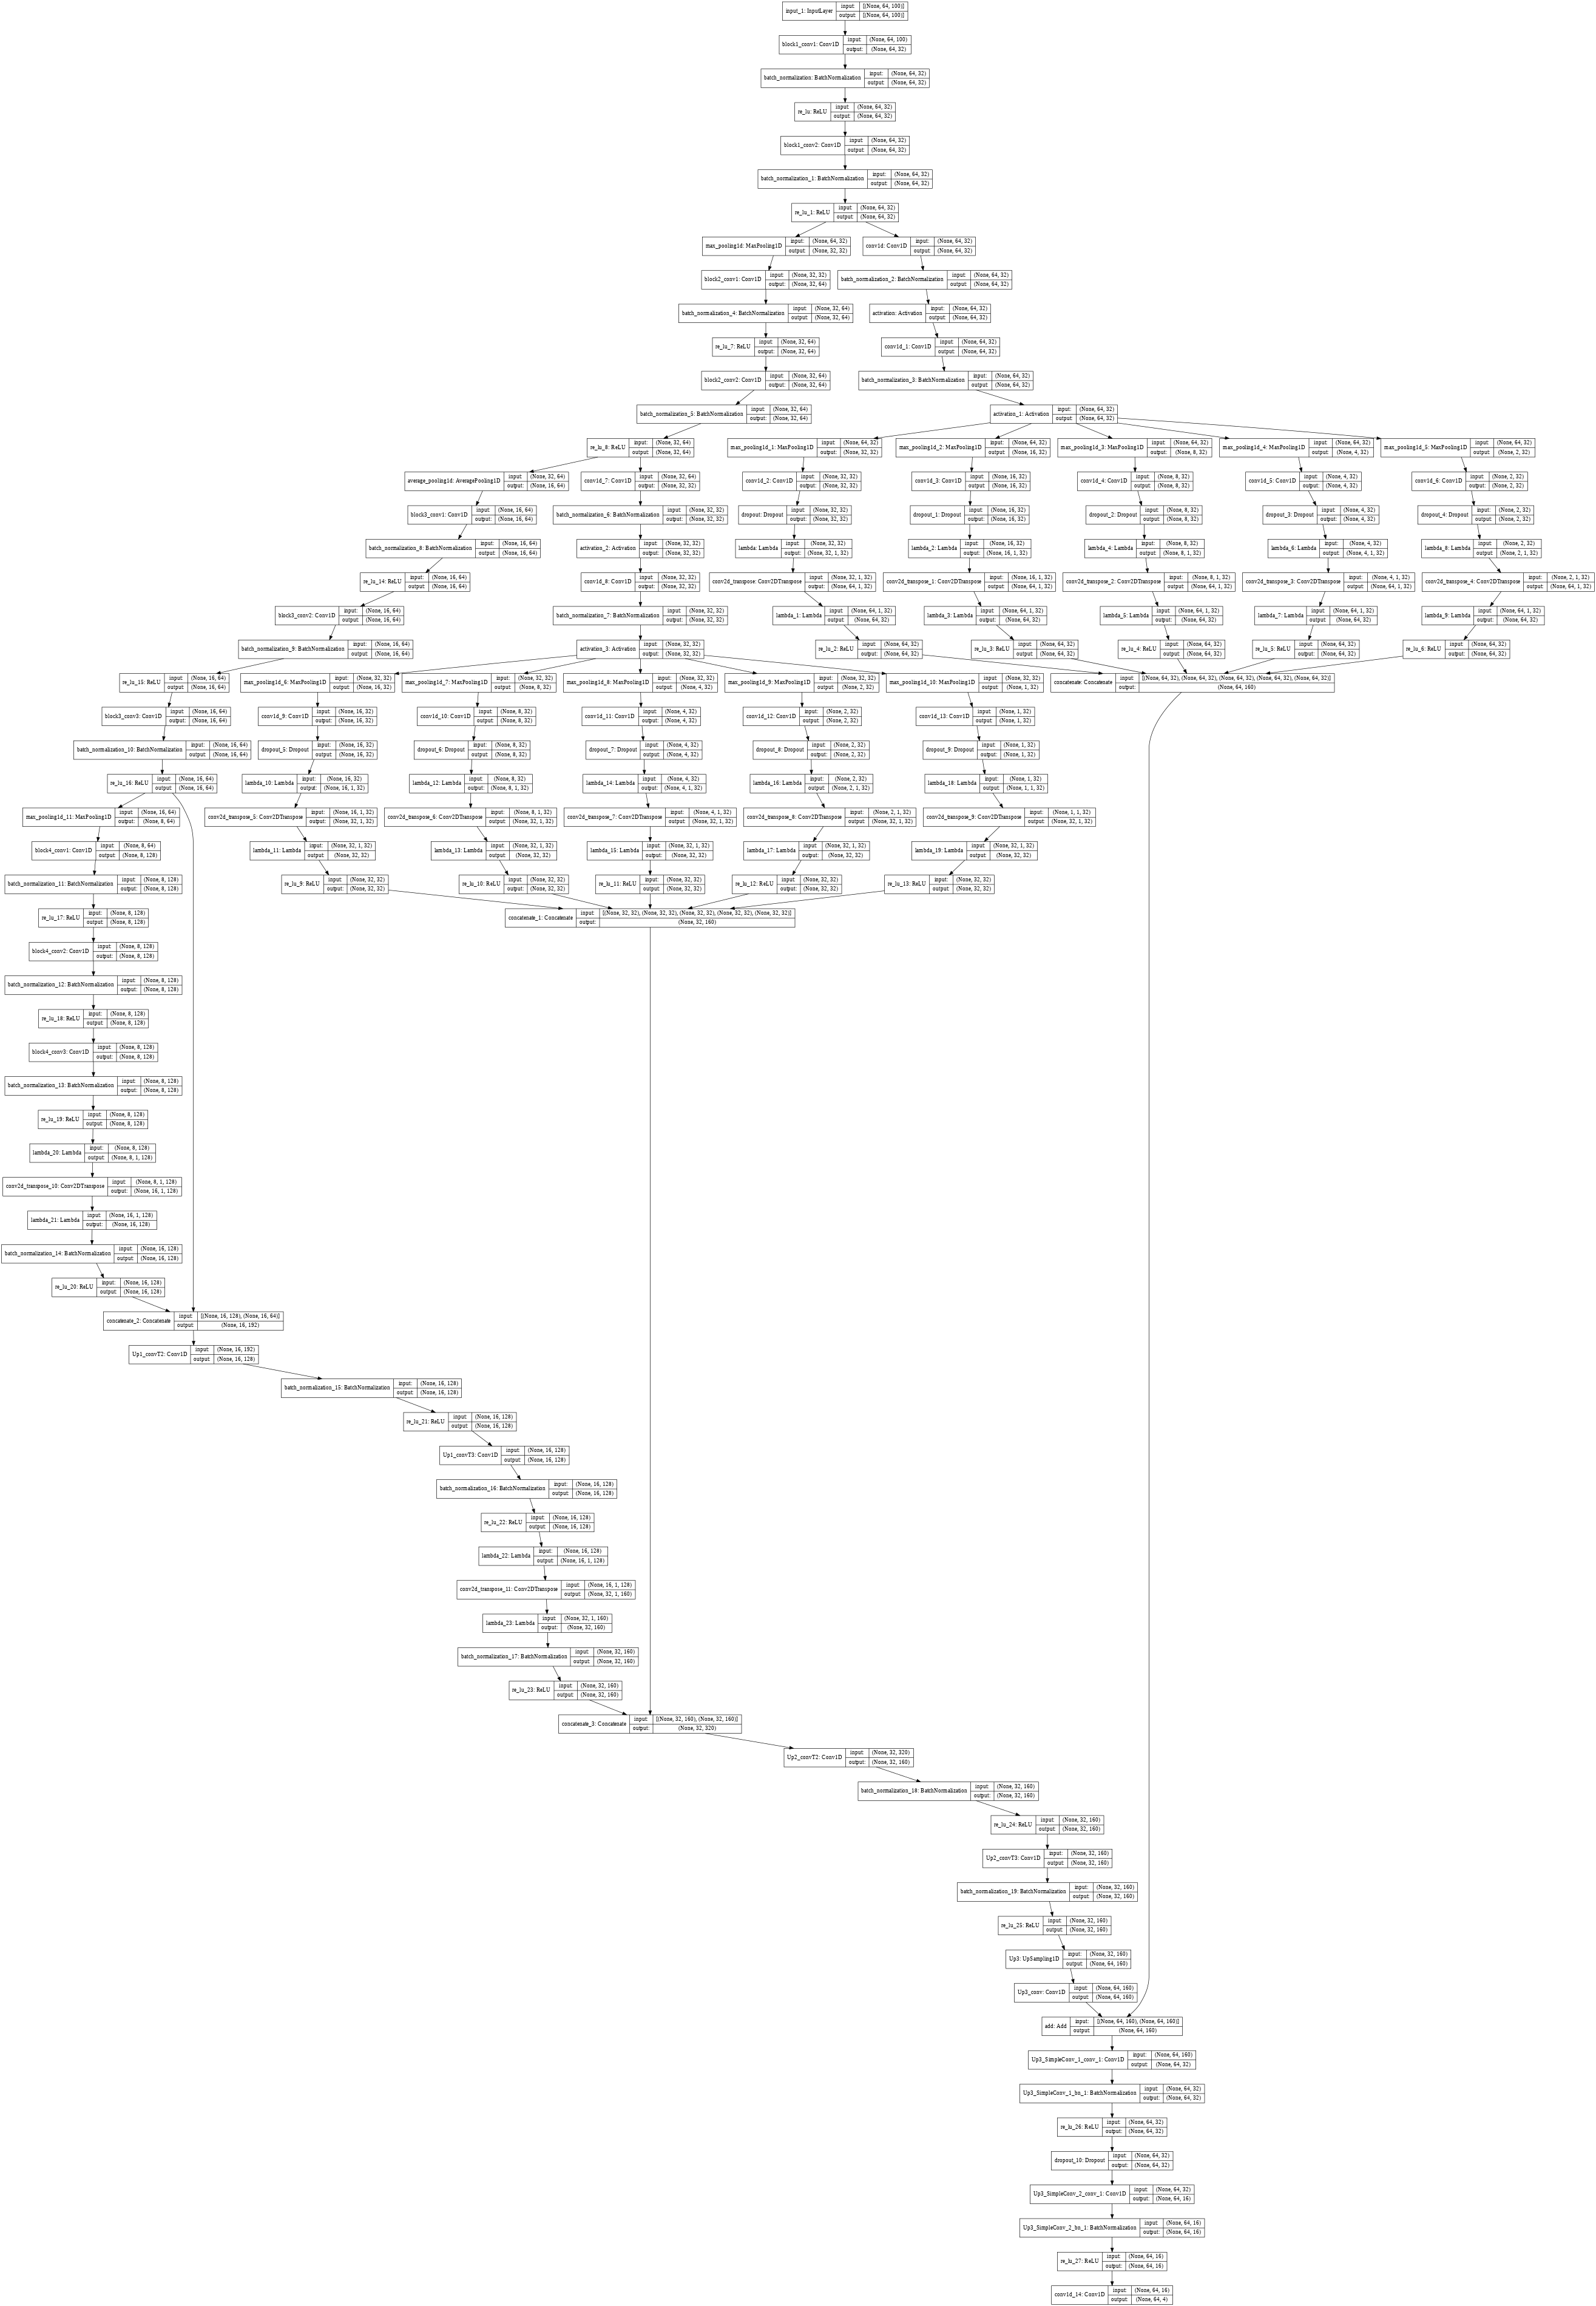

In [ ]:
text_segmentation = segmentation_wrap(xTrainGENSIM_100, yTrainGENSIM_100, tagsCount)
utils.plot_model(text_segmentation.model, show_shapes=True, show_layer_names=True, dpi=48)

Эпоха 50 из 50,50
444/556,444


Эпоха,loss,dice_coef,val_loss,val_dice_coef
0,0.482,0.421,0.327,0.567
1,0.284,0.573,0.226,0.689
2,0.205,0.672,0.197,0.744
3,0.165,0.734,0.201,0.773
4,0.141,0.776,0.201,0.793
5,0.123,0.806,0.209,0.808
6,0.108,0.831,0.212,0.812
7,0.096,0.85,0.236,0.82
8,0.085,0.867,0.228,0.823
9,0.077,0.881,0.244,0.825


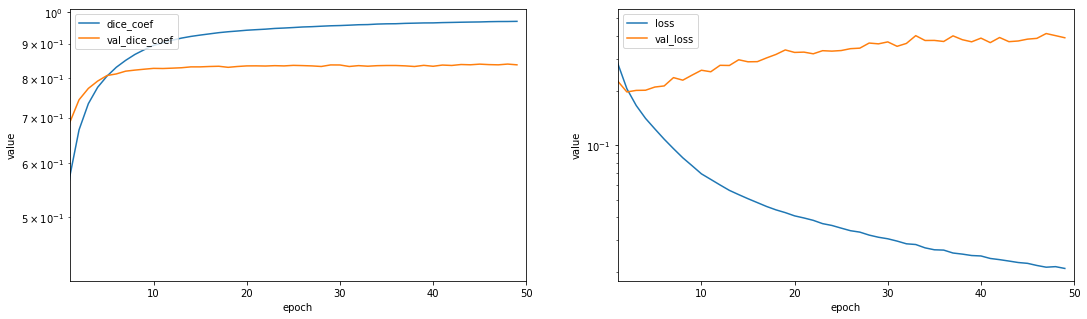

In [ ]:
text_segmentation.recompile(lr = 1e-4)
text_segmentation.fit(epochs = 50, batch_size = 64)

Эпоха 50 из 50,50
444/556,444


Эпоха,loss,dice_coef,val_loss,val_dice_coef
0,0.482,0.421,0.327,0.567
1,0.284,0.573,0.226,0.689
2,0.205,0.672,0.197,0.744
3,0.165,0.734,0.201,0.773
4,0.141,0.776,0.201,0.793
5,0.123,0.806,0.209,0.808
6,0.108,0.831,0.212,0.812
7,0.096,0.85,0.236,0.82
8,0.085,0.867,0.228,0.823
9,0.077,0.881,0.244,0.825


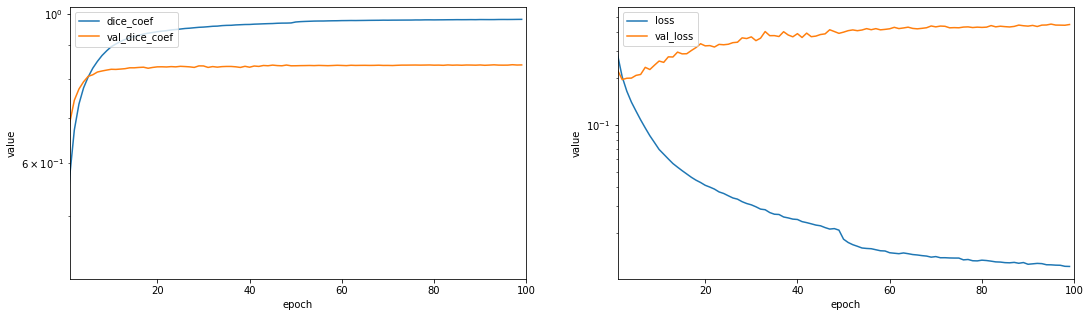

In [ ]:
# Досчитываем с более мелким шагом
text_segmentation.recompile(lr = 1e-5)
text_segmentation.fit(epochs = 50, batch_size = 64)

In [ ]:
text_segmentation.model.save(mainDir+'/big-net-model.h5')
text_segmentation.model.save_weights(mainDir+'/big-net.hdf5')

In [ ]:
model.save(mainDir+'/unet-model.h5')

In [ ]:
# Сохранение модели для Serving

MODEL_DIR = '/content/marketing_model'# создание временной директории для хранения модели
version = 1  # номер нашей версии
export_path = os.path.join(MODEL_DIR, str(version))
print('Путь для экспорта = {}\n'.format(export_path))

if os.path.isdir(export_path):
  print('\nМодель уже сохранена\n')
  !rm -rf {export_path}

Путь для экспорта = /content/marketing_model/1



In [ ]:
import tensorflow as tf
tf.keras.models.save_model(
    text_segmentation.model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nСохраненная модель:')
!ls -l {export_path}

INFO:tensorflow:Assets written to: /content/marketing_model/1/assets

Сохраненная модель:
total 3620
drwxr-xr-x 2 root root    4096 Feb 26 10:51 assets
-rw-r--r-- 1 root root 3698232 Feb 26 10:51 saved_model.pb
drwxr-xr-x 2 root root    4096 Feb 26 10:51 variables


In [ ]:
# Сливаем модель в один файл и архивируем, чтобы можно было скачать одним файлом
tar_file = "marketing_model_" + str(version) + ".tgz"

!tar -zcvf {tar_file} {export_path}

tar: Removing leading `/' from member names
/content/marketing_model/1/
/content/marketing_model/1/variables/
/content/marketing_model/1/variables/variables.index
/content/marketing_model/1/variables/variables.data-00000-of-00001
/content/marketing_model/1/saved_model.pb
/content/marketing_model/1/assets/
